In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.fft import fft, ifft, fftfreq
import matplotlib
import bagpy
from bagpy import bagreader
import pandas as pd
from scipy.signal import argrelextrema
from matplotlib.colors import LogNorm
from matplotlib import colors
import seaborn as sns 
import random

matplotlib.rcParams.update({'font.size': 18})

In [2]:
def closest(lst, K):
    lst = np.asarray(lst)
    idx = (np.abs(lst - K)).argmin()
    return int(idx)

In [3]:
# constants
c_0 = 3e8 # speed of light
microsteps = 800 # steps/rev
pitch = 5 # mm/rev
stepspermm = microsteps/pitch


# FMCW parameters
size_SAR_x = 400 # mm
size_SAR_y = 400 # mm

dy_sampling = 1 # mm
dx_motion_step = 1 # mm
num_x = size_SAR_x/dx_motion_step #
num_y = size_SAR_y/dy_sampling #
n_frms = int(1.30 * num_x * num_y)

v_testbed = 20.0 # mm/s
dt = dy_sampling/v_testbed # second

dCfg        =   {
                    "fStrt"     :   76e9,
                    "fStop"     :   78e9,
                    "TRampUp"   :   64e-6,
                    "TRampDo"   :   32e-6,
                    "TInt"      :   dt,
                    "N"         :   256,
                    "NrFrms"    :   n_frms,
                    "IniTim"    :   1000e-3,
                    "IniEve"    :   0
                }
n_ch = 1

file_exp = "43"
# output folder
#folder_output = '/home/qiwen/Github/UA_SAR/code/Analysis/RDA_2D_test_Feb/exp%s/'%file_exp
#folder_output = '/home/qiwen/Github/UA_SAR/code/Analysis/RDA_investigations/t_%ds/exp%s/'%(t_sar_actual,file_exp)
#folder_output = '/home/wq3939390/SAR_project/code/Analysis/Motion_Emulation/1Ddata/exp%s/'%file_exp
#folder_output = '/home/qiwen/Github/SAR_project/code/Analysis/motion_error_Sep2022/exp%s/'%file_exp
folder_output = '/home/wq3939390/SAR_project/code/Analysis/motion_error_Sep2022/exp%s/'%file_exp

In [4]:
# load motion data
df_grid = pd.read_pickle(folder_output+"2D_grid.pkl")

In [5]:
# load radar time data
path = '/home/wq3939390/SAR_project/code/Radarbook/Python/PyAppNotes/output/20221019/'
#path = '/home/qiwen/Github/SAR_project/data/20220302/'
data_time = np.loadtxt(path + "SAR_time_exp%s.csv"%file_exp, delimiter = ',')
#data_radar = np.loadtxt(path + "SAR_data_exp%s.csv"%file_exp, delimiter = ',', dtype=complex)
data_R = np.loadtxt(path + "R_exp%s.txt"%file_exp, delimiter = ',')

In [6]:
# reshape radar data to match slowtime-fasttime-channel
#data_radar = data_radar.reshape(n_frms,data_R.shape[0],n_ch)

-0.008762276578283802
17.04345710793327
-17.06102493289762


Text(0, 0.5, 'Velocity / mm/s')

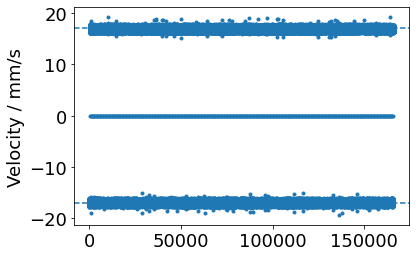

In [7]:
# find speed in y, useful for estimate errors of grid mapping
v = (np.diff(df_grid['y [mm]']))/np.diff(df_grid['Time']) # mm/s
v0 = np.mean(v[v>5])
plt.plot(v,'.')
print(np.mean(v))
print(np.mean(v[v>5]))
print(np.mean(v[v<-5]))
plt.axhline(np.mean(v[v>5]),ls='--')
plt.axhline(np.mean(v[v<-5]),ls='--')
plt.ylabel('Velocity / mm/s')

In [8]:
# check the dimensions
print(df_grid)
#print(data_radar.shape)
#print(data_R.shape)
print(data_time.shape)

                Time  y [mm]  x [mm]
518     1.666229e+09   405.0       0
519     1.666229e+09   404.0       0
520     1.666229e+09   403.0       0
521     1.666229e+09   402.0       0
522     1.666229e+09   401.0       0
...              ...     ...     ...
166972  1.666239e+09   401.0     409
166973  1.666239e+09   402.0     409
166974  1.666239e+09   403.0     409
166975  1.666239e+09   404.0     409
166976  1.666239e+09   405.0     409

[166050 rows x 3 columns]
(208000,)


In [9]:
# find the nearest time of radar data to map to the grid
delta_idx_error = 0

idx_radar = np.zeros((df_grid.shape[0],),dtype=int)
for k in range(df_grid.shape[0]):
    if k == 0:
        idx_radar[k]=closest(data_time, df_grid['Time'][df_grid.index[k]])
    else:
        idx_radar[k]=idx_radar[k-1]+closest(data_time[idx_radar[k-1]:idx_radar[k-1]+20000], df_grid['Time'][df_grid.index[k]]) # limit the range for each search

# add randomness to the index
idx_radar = idx_radar + np.round(np.random.normal(scale=delta_idx_error,size=(df_grid.shape[0],))) 
idx_radar[idx_radar<0] = 0
idx_radar = idx_radar.astype(int)

df_grid['idx_radar'] = idx_radar 
df_grid['time_radar'] = data_time[idx_radar]
df_grid['time_error [ms]'] = 1e3*(df_grid['time_radar']-df_grid['Time'])
df_grid['abs(time_error) [ms]'] = abs(df_grid['time_error [ms]'])
df_grid['position_error [mm]'] = 1e-3*v0*df_grid['abs(time_error) [ms]']

df_grid

,Time,y [mm],x [mm],idx_radar,time_radar,time_error [ms],abs(time_error) [ms],position_error [mm]
518,1.666229e+09,405.0,0,322,1.666229e+09,10.699034,10.699034,0.182349
519,1.666229e+09,404.0,0,323,1.666229e+09,2.867699,2.867699,0.048875
520,1.666229e+09,403.0,0,324,1.666229e+09,-4.037619,4.037619,0.068815
521,1.666229e+09,402.0,0,325,1.666229e+09,-13.719559,13.719559,0.233829
522,1.666229e+09,401.0,0,326,1.666229e+09,-21.650553,21.650553,0.369000
...,...,...,...,...,...,...,...,...
166972,1.666239e+09,401.0,409,207877,1.666239e+09,-17.901897,17.901897,0.305110
166973,1.666239e+09,402.0,409,207879,1.666239e+09,24.817228,24.817228,0.422971
166974,1.666239e+09,403.0,409,207880,1.666239e+09,14.538527,14.538527,0.247787
166975,1.666239e+09,404.0,409,207881,1.666239e+09,7.731676,7.731676,0.131774


Below is analysis on the time and position mismatch

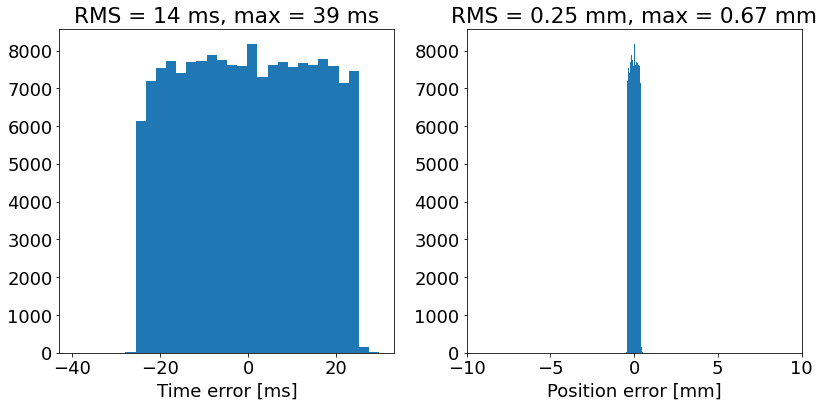

In [10]:
# error in time and position
rms_time = np.sqrt(np.mean(df_grid['time_error [ms]']**2))

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].hist(df_grid['time_error [ms]'],bins=30)
ax[1].hist(1e-3*v0*df_grid['time_error [ms]'],bins=30)

ax[0].set_title('RMS = %d ms, max = %d ms'%(rms_time, max(abs(df_grid['time_error [ms]']))))
ax[1].set_title('RMS = %.2f mm, max = %.2f mm'%(rms_time*1e-3*v0, 1e-3*v0*max(abs(df_grid['time_error [ms]']))))
ax[0].set_xlabel('Time error [ms]')
ax[1].set_xlabel('Position error [mm]')
ax[1].set_xlim(-10,10)
plt.tight_layout()
fig.savefig(folder_output+"grid_mapping_error.jpg")
plt.show()

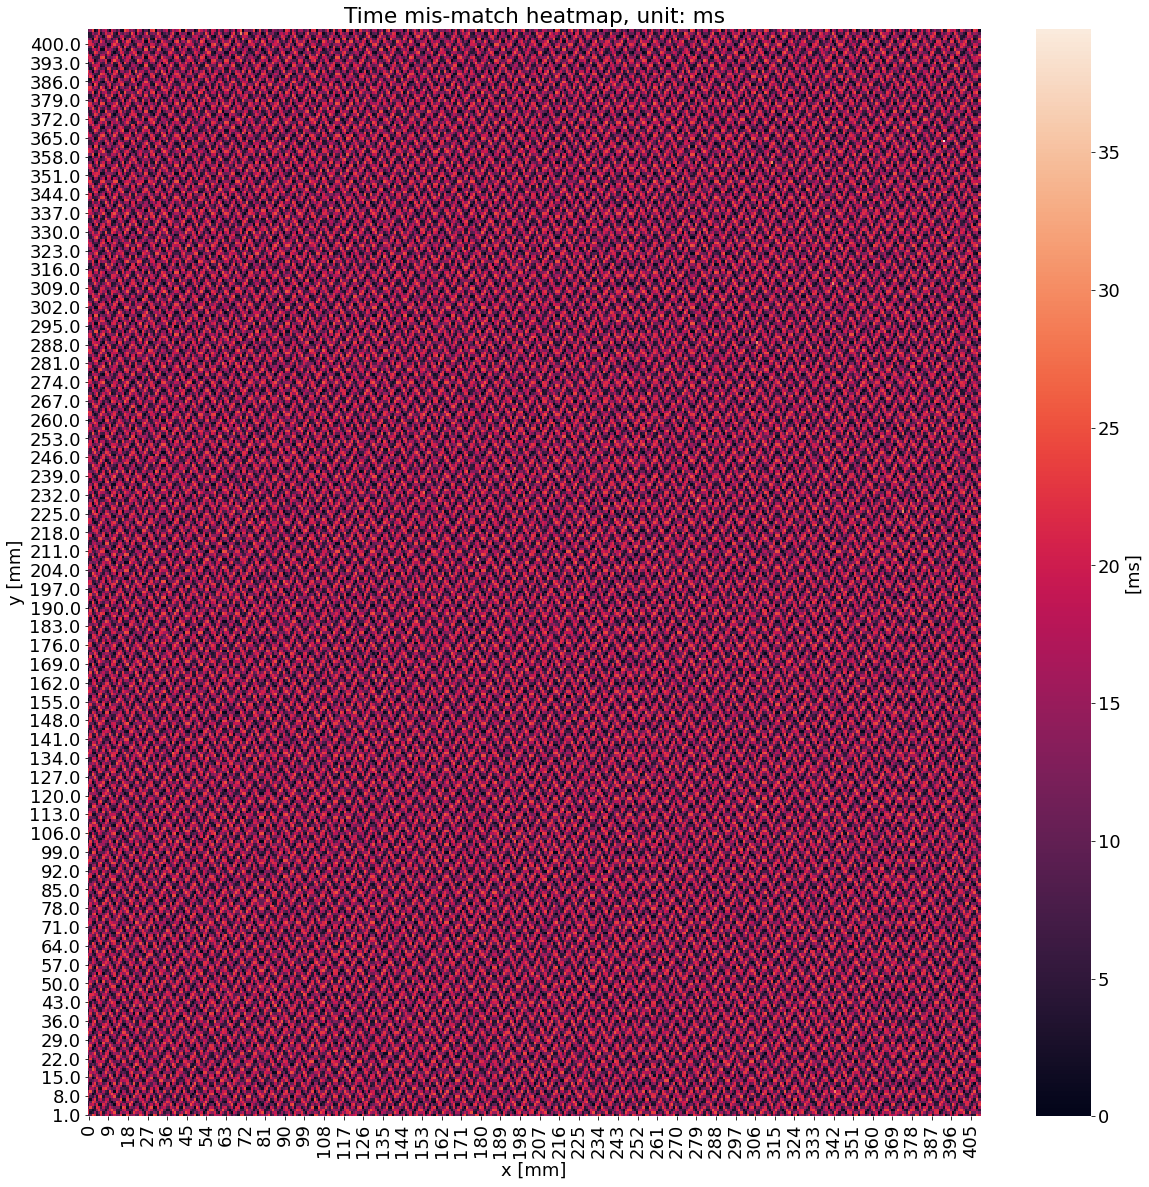

In [11]:
fig = plt.figure(figsize=(20,20))
table = df_grid.pivot('y [mm]', 'x [mm]', 'abs(time_error) [ms]')
ax = sns.heatmap(table,cbar_kws={'label': '[ms]'})
ax.invert_yaxis()
plt.title("Time mis-match heatmap, unit: ms")
fig.savefig(folder_output+"grid_mapping_error_heatmap.jpg")
plt.show()

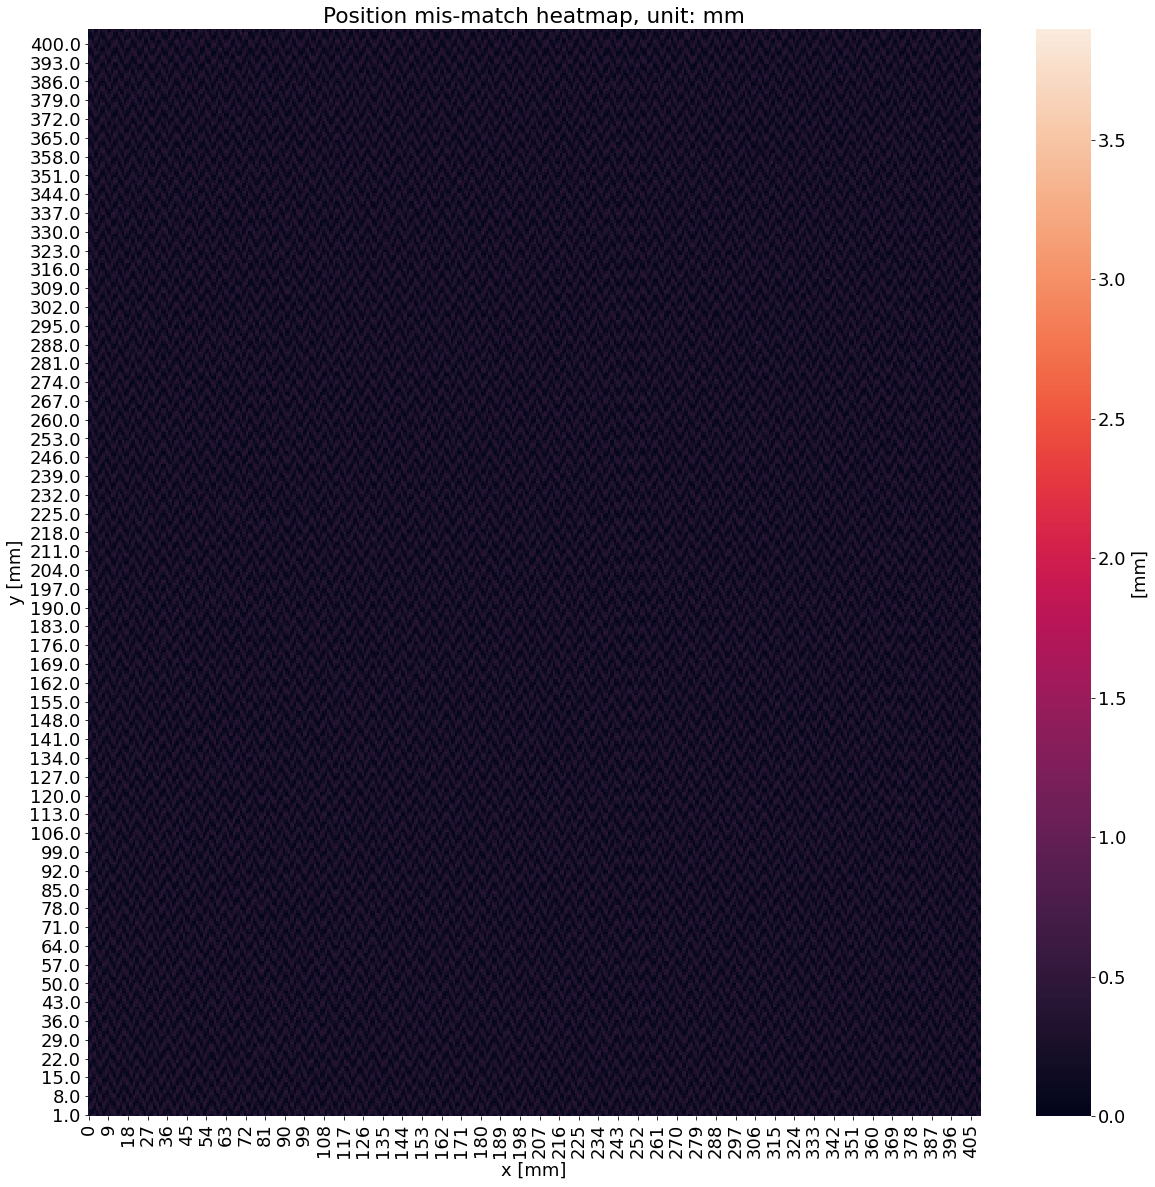

In [12]:
wavelength = c_0/(0.5*(dCfg["fStrt"] + dCfg["fStop"]))
fig = plt.figure(figsize=(20,20))
table = df_grid.pivot('y [mm]', 'x [mm]', 'position_error [mm]')
ax = sns.heatmap(table,cbar_kws={'label': '[mm]'}, vmin=0, vmax=wavelength*1e3)
ax.invert_yaxis()
plt.title("Position mis-match heatmap, unit: mm")
#fig.savefig(folder_output+'grid_mapping_PositionError_heatmap.jpg')
fig.savefig(folder_output+"grid_mapping_PositionError_heatmap.jpg")
plt.show()

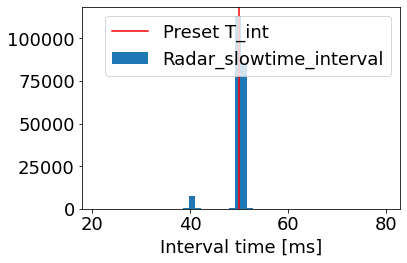

In [13]:
plt.hist(1e3*np.diff(data_time)[1:],bins=50,label='Radar_slowtime_interval')
plt.axvline(dt*1e3,color='red',label='Preset T_int')
plt.xlabel('Interval time [ms]')
plt.legend()
plt.tight_layout()
plt.savefig(folder_output+'radar_time_hist.jpg')


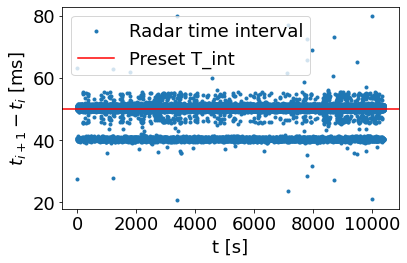

In [14]:
plt.plot(data_time[2:]-data_time[2],1e3*(np.diff(data_time)[1:]),'.',label='Radar time interval')
plt.axhline(1e3*dt,color='red',label='Preset T_int')
plt.xlabel('t [s]')
plt.ylabel(r'$t_{i+1}-t_{i}$ [ms]')
plt.legend()
plt.tight_layout()
plt.savefig(folder_output+'radar_time_error.jpg')

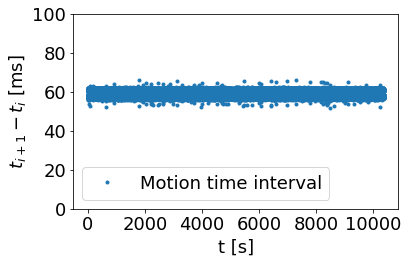

In [15]:
t_diff = np.diff(df_grid['Time'])
t = np.array(df_grid['Time'])
plt.plot(t[1:]-t[0],1e3*t_diff ,'.',label='Motion time interval')
plt.ylim(0,100)
#plt.axhline(1e3*dt,color='red',label='Preset T_int')
plt.xlabel('t [s]')
plt.ylabel(r'$t_{i+1}-t_{i}$ [ms]')
plt.legend()
plt.tight_layout()
plt.savefig(folder_output+'motion_time.jpg')

In [16]:
df_grid

,Time,y [mm],x [mm],idx_radar,time_radar,time_error [ms],abs(time_error) [ms],position_error [mm]
518,1.666229e+09,405.0,0,322,1.666229e+09,10.699034,10.699034,0.182349
519,1.666229e+09,404.0,0,323,1.666229e+09,2.867699,2.867699,0.048875
520,1.666229e+09,403.0,0,324,1.666229e+09,-4.037619,4.037619,0.068815
521,1.666229e+09,402.0,0,325,1.666229e+09,-13.719559,13.719559,0.233829
522,1.666229e+09,401.0,0,326,1.666229e+09,-21.650553,21.650553,0.369000
...,...,...,...,...,...,...,...,...
166972,1.666239e+09,401.0,409,207877,1.666239e+09,-17.901897,17.901897,0.305110
166973,1.666239e+09,402.0,409,207879,1.666239e+09,24.817228,24.817228,0.422971
166974,1.666239e+09,403.0,409,207880,1.666239e+09,14.538527,14.538527,0.247787
166975,1.666239e+09,404.0,409,207881,1.666239e+09,7.731676,7.731676,0.131774


In [17]:
df_grid.to_pickle(folder_output+"2D_grid_mapped.pkl")

In [18]:
# load radar data
data_radar = np.loadtxt(path + "SAR_data_exp%s.csv"%file_exp, delimiter = ',', dtype=complex)
# reshape radar data to match slowtime-fasttime-channel
data_radar = data_radar.reshape(n_frms,data_R.shape[0],n_ch)

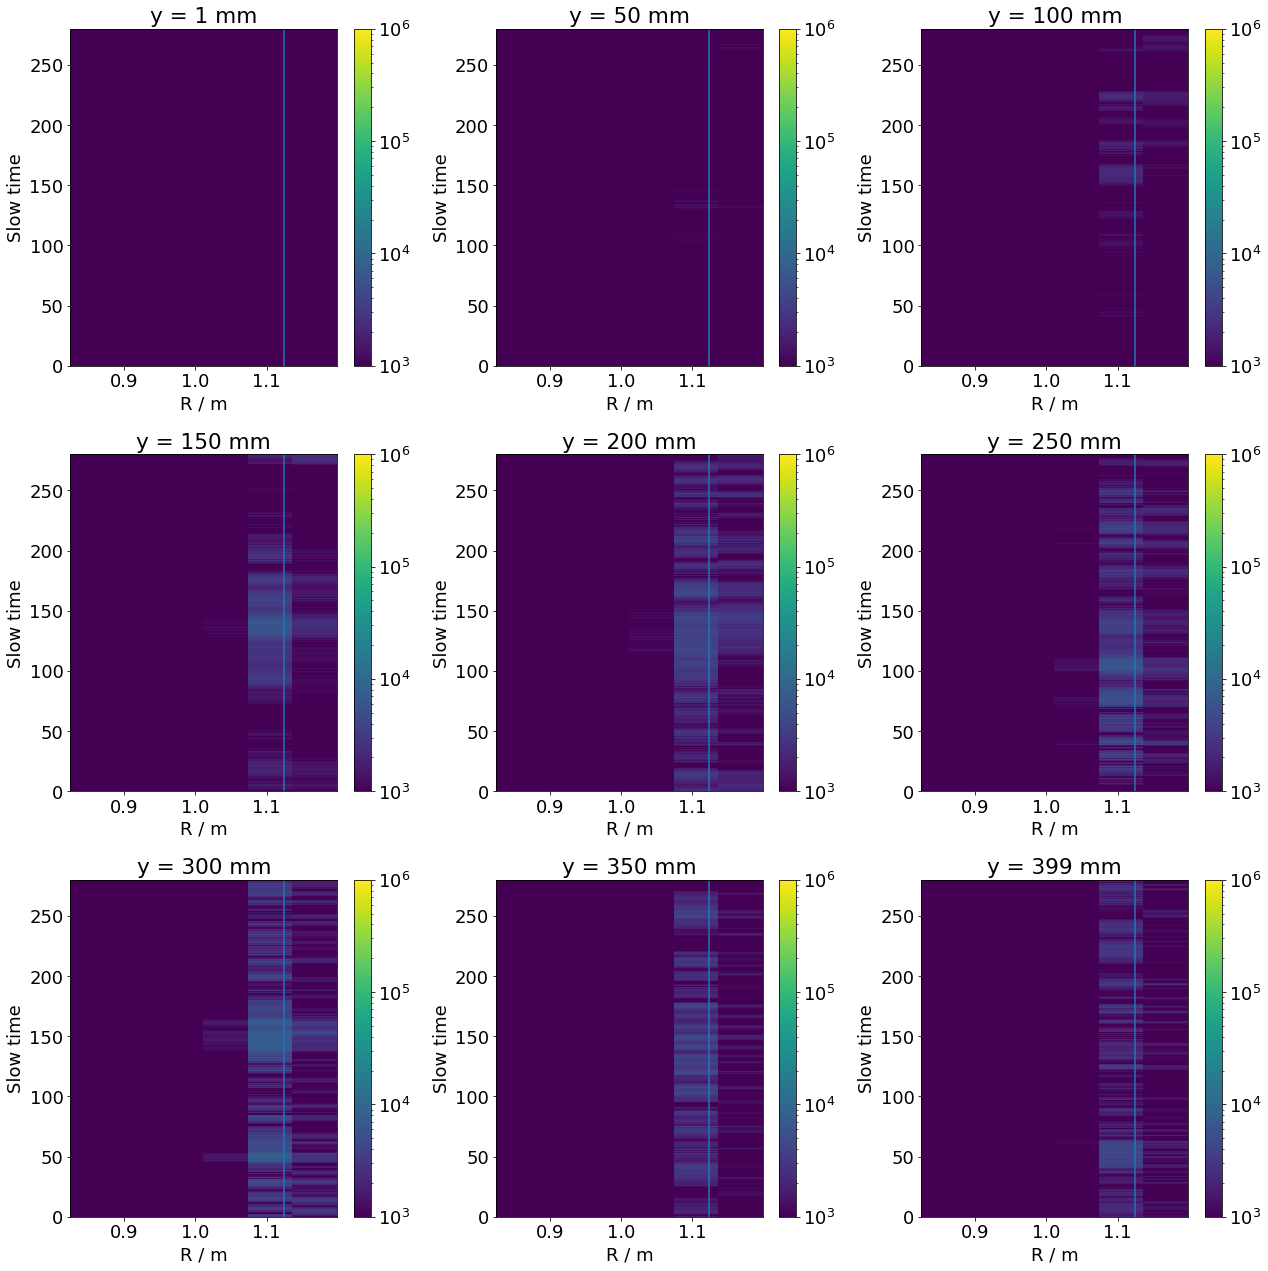

In [19]:
ch=0

fig, ax = plt.subplots(3,3, figsize=(18,18))
#fig.suptitle('Ch:%d'%ch)
for k,y in enumerate([1,50, 100, 150, 200, 250, 300, 350,399]):
    df_y = df_grid[df_grid['y [mm]']==y]
    df_y['idx_radar'].tolist()
    data_radar_y = data_radar[df_y['idx_radar'].tolist()]
    
    ax[int(k/3),k%3].set_title('y = %d mm'%(y))
    

    
    z1_plot = ax[int(k/3),k%3].imshow((np.abs(data_radar_y[:,:,ch])),extent = [np.min(data_R),np.max(data_R),0,280],norm=LogNorm(vmin=1e3, vmax=1e6),interpolation='none', aspect='auto', origin = 'lower')
    #z1_plot = ax[int(k/3),k%3].imshow((np.abs(data_radar_y[:,:,ch])),extent = [np.min(data_R),np.max(data_R),0,280],interpolation='none', aspect='auto', origin = 'lower')
    ax[int(k/3),k%3].axvline(data_R[4])
    ax[int(k/3),k%3].set_xlabel('R / m')
    ax[int(k/3),k%3].set_ylabel('Slow time')
    plt.colorbar(z1_plot,ax=ax[int(k/3),k%3])
plt.tight_layout()

In [20]:
# store the radar data into dataframe
#
#for idx_maxP in range(0,len(data_R)):
#    a = data_radar[df_grid['idx_radar'].tolist()]
#    df_grid['radar_ch1'] = a[:,idx_maxP,0]
#    df_grid['radar_ch2'] = a[:,idx_maxP,1]
#    df_grid.to_pickle(folder_output+"Y_only/MotionError_mu_%d/2D_grid_mapped_R0_idx%d.pkl"%(delta_idx_error,idx_maxP))
#    df_grid